In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

## Load dataset

### The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed. 

   There are two datasets: 
      1) bank-full.csv with all examples, ordered by date (from May 2008 to November 2010).
      2) bank.csv with 10% of the examples (4521), randomly selected from bank-full.csv.
   The smallest dataset is provided to test more computationally demanding machine learning algorithms (e.g. SVM).

   The classification goal is to predict if the client will subscribe a term deposit (variable y).
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
### related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
### other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [3]:
df = pd.read_csv('bank-full.csv', sep=';')

## Review of data

In [20]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [17]:
len(df) - df.count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### overview of the target

In [10]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

### overview of the quantitative features

In [12]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### overview of the categorical features


In [31]:
for col in df.select_dtypes(include='object').columns:
    print(str(col) +'\n\n' + str(df[col].value_counts()) +'\n' + '*'*100 + '\n')

job

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
****************************************************************************************************

marital

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
****************************************************************************************************

education

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
****************************************************************************************************

default

no     44396
yes      815
Name: default, dtype: int64
****************************************************************************************************

housing

yes    25130
no    

## Feature enegineering

In [4]:
cat_var = [i for i in df.select_dtypes(include='object')]

In [5]:
bin_var = [i for i in cat_var if len(df[i].value_counts())<=2]

In [6]:
for col in bin_var:
    df[col] = df[col].map({'yes':1, 'no':0})

In [7]:
for cat_col in cat_var:
    df[cat_col] = df[cat_col].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  y          45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [9]:
cat_cols = df.select_dtypes(['category']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)

In [10]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


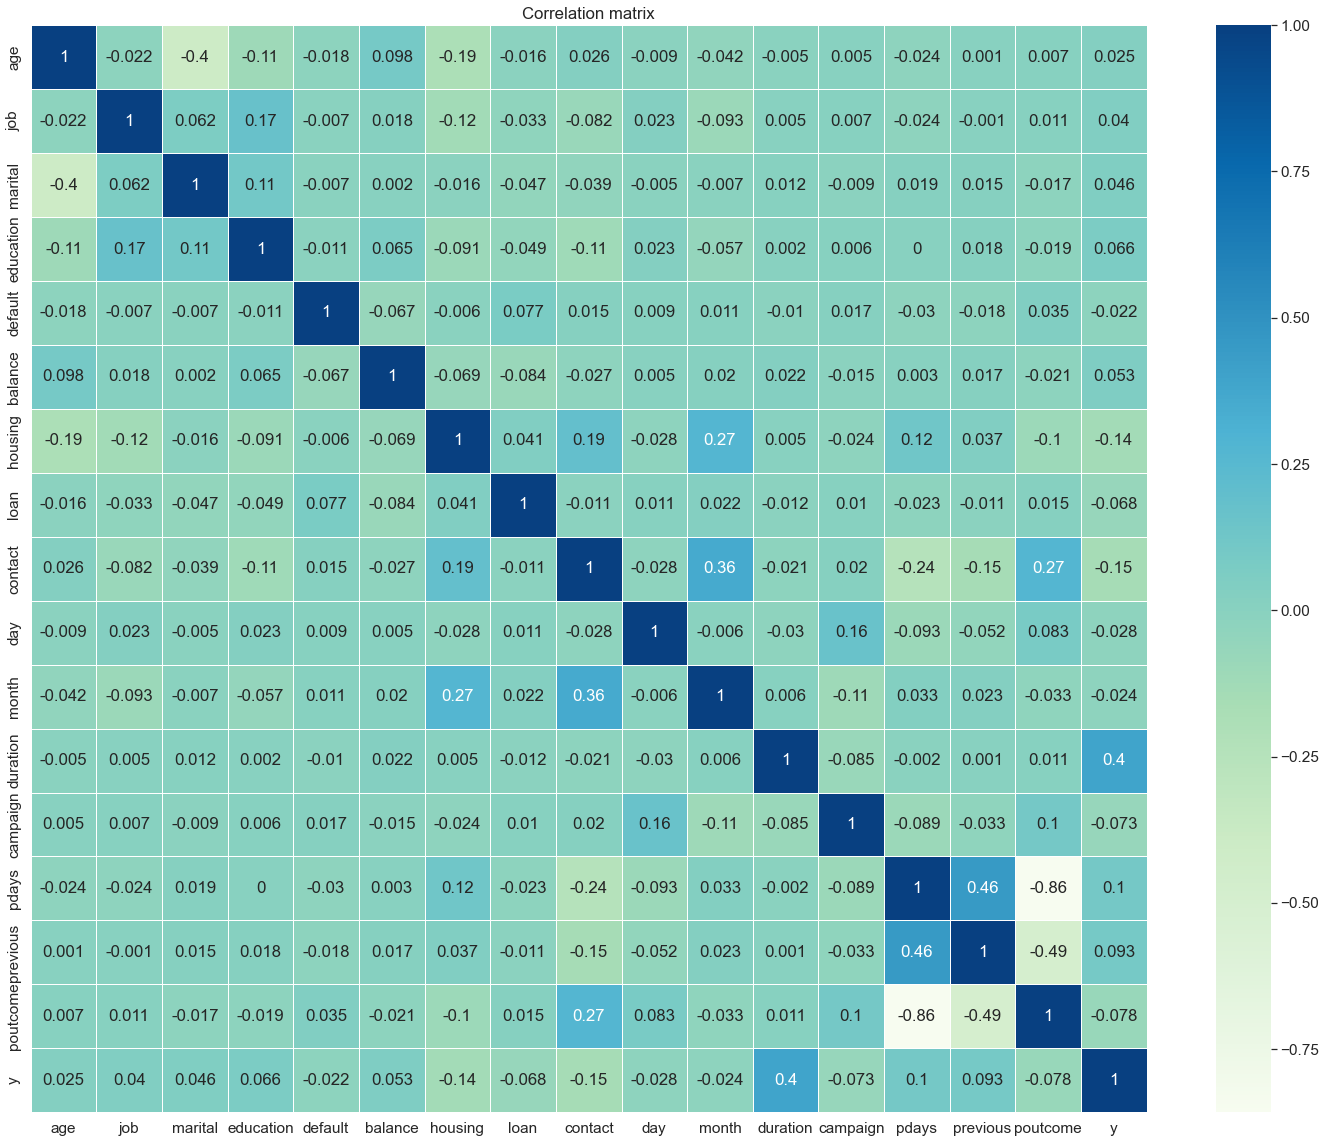

In [11]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels='y',axis=1), df['y'], random_state=42)

In [13]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_predict_proba = model.predict_proba(X_test)[:, 1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:14:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=y_predict)

Best Threshold=1.000, F-Score=0.551, Precision=0.645, Recall=0.480


In [1]:
import shap

In [16]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])
shap.initjs()

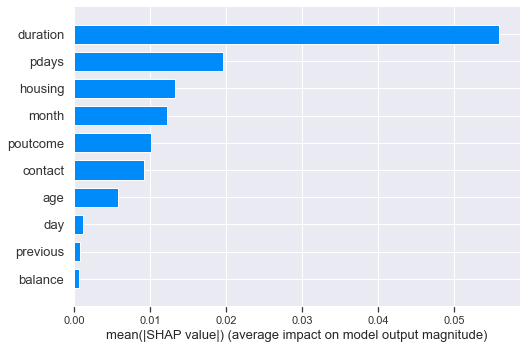

In [17]:
shap.summary_plot(shap_values=shap_values, features=X_test, plot_type='bar', max_display=10)

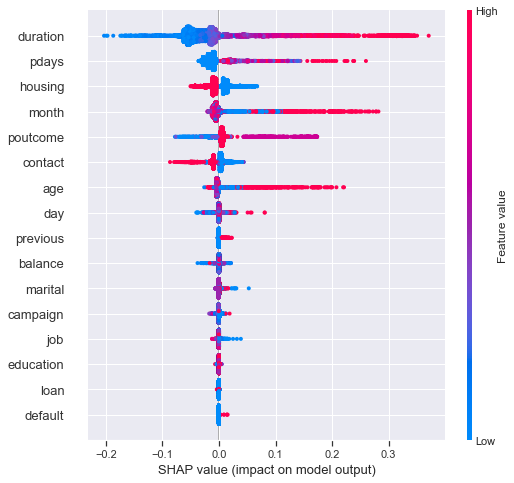

In [18]:
shap.summary_plot(shap_values, X_test)

### top of 10

In [19]:
preds = y_predict_proba
X_test_10 = X_test
dif = np.abs(y_test - preds).reset_index(drop=True)
X_test_10['dif'] = dif
length_10 = round(len(X_test_10) * 0.1)
X_test_10 = X_test_10.sort_values(by=['dif']).iloc[: length_10, :]
X_test_10 = X_test_10.drop('dif', 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


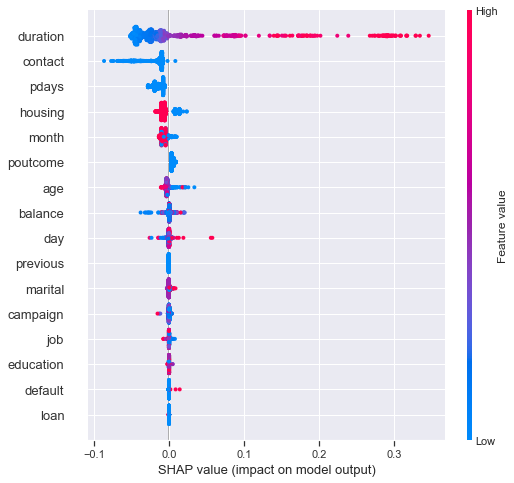

In [20]:
shap_values = explainer.shap_values(X_test_10)
shap.summary_plot(shap_values, X_test_10)

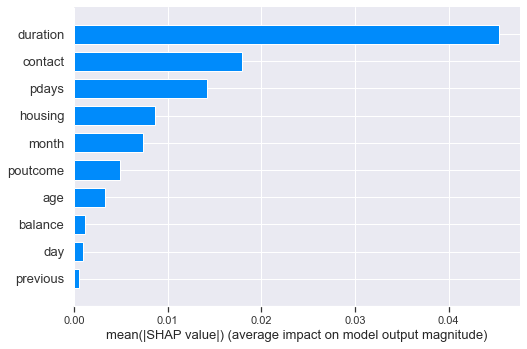

In [21]:
shap.summary_plot(shap_values=shap_values, features=X_test_10, plot_type='bar', max_display=10)